🚀 Starting Memory-Efficient Audio Compression...
Configuration: 75% compression, Binary matrix, auto method
Loading your audio file: UrbanSound8K/any_wav.wav
Target compression: 75%
Using Binary random matrix
Processing: 99225 samples, 44100 Hz
Duration: 2.25 seconds

⚠️  Large signal detected. Using memory-efficient threshold method...
Applying DWT threshold compression...
Compression ratio: 75.0%
Compression threshold: 0.002068
Compression achieved: 24.2% coefficients removed
Actual compression: 75.0% coefficients retained

=== Results (DWT Threshold Compression (24.2%)) ===
Reconstruction MSE: 0.000000
Reconstruction SNR: 48.51 dB


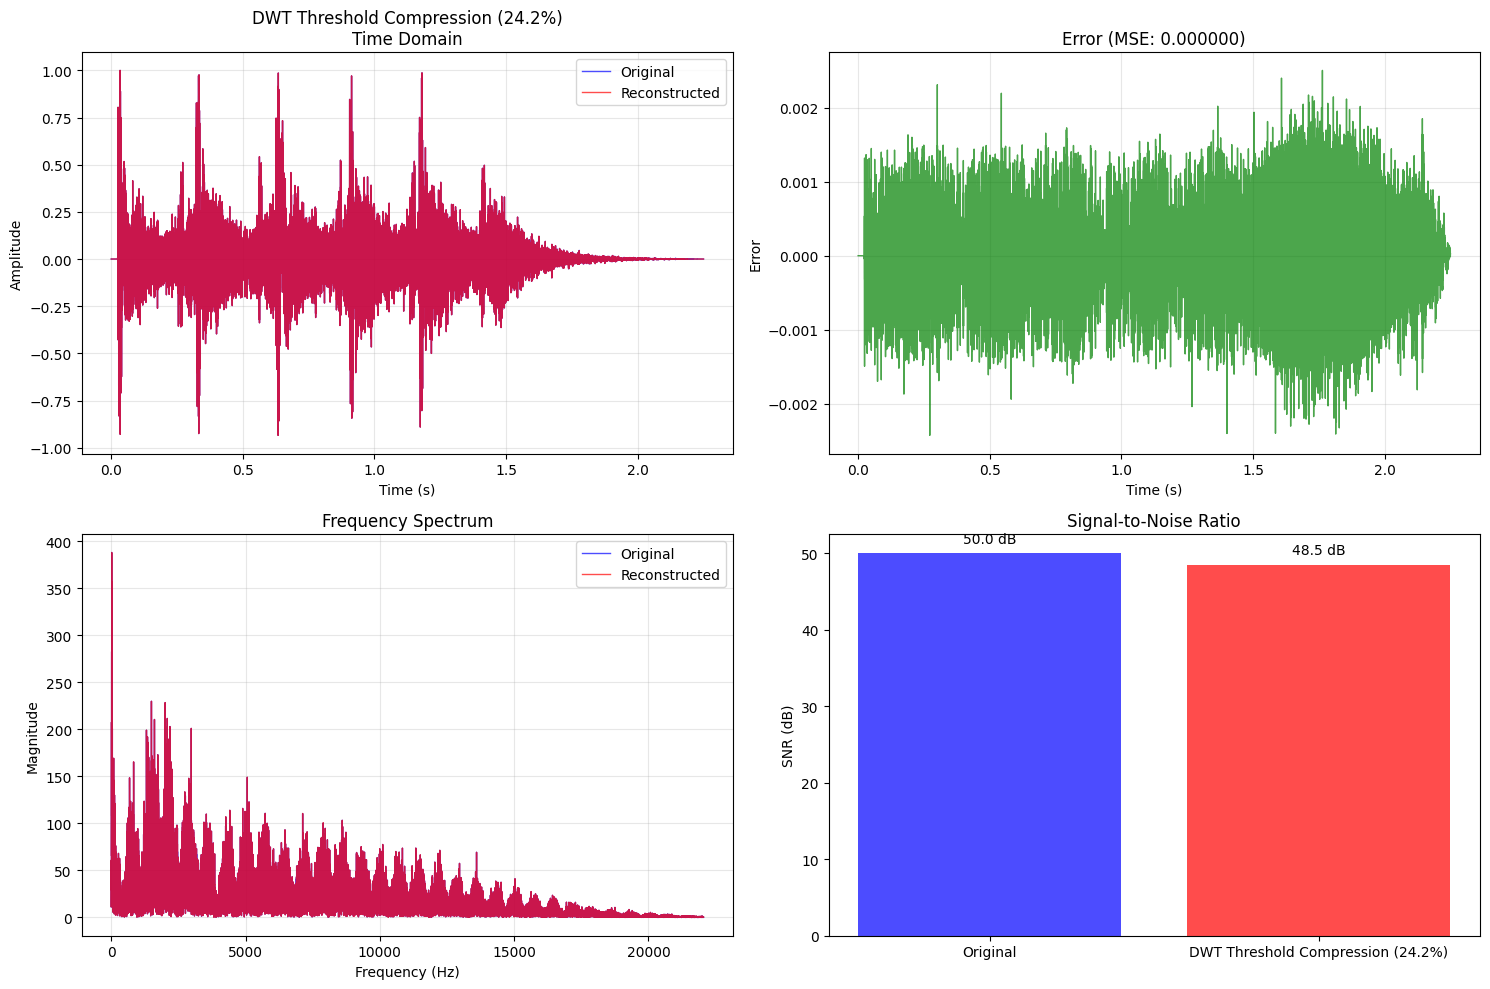


✅ Audio files saved in 'compression_results' folder:
   - any_wav_original.wav
   - any_wav_compressed_24percent.wav
🎉 Compression completed successfully!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import wavfile
import librosa
import os

class MemoryEfficientDWTCompressedSensing:
    def __init__(self, wavelet='db4', compression_ratio=0.5, use_binary_matrix=True):
        self.wavelet = wavelet
        self.compression_ratio = compression_ratio
        self.use_binary_matrix = use_binary_matrix
        
    def _generate_random_matrix(self, rows, cols):
        """Generate random matrix (binary or Gaussian)"""
        if self.use_binary_matrix:
            # Binary random matrix: elements are +1 or -1 with equal probability
            return np.sign(np.random.randn(rows, cols))
        else:
            # Standard Gaussian random matrix
            return np.random.randn(rows, cols)
    
    def memory_efficient_compression(self, audio_data, level=4):
        """Memory-efficient compressed sensing using block processing"""
        print("Applying memory-efficient compressed sensing...")
        print(f"Using {'Binary' if self.use_binary_matrix else 'Gaussian'} random matrix")
        
        # Use shorter DWT level for longer signals
        max_possible_level = pywt.dwt_max_level(len(audio_data), self.wavelet)
        level = min(level, max_possible_level, 6)  # Limit to level 6 max
        
        print(f"Using DWT level: {level}")
        print(f"Compression ratio: {self.compression_ratio*100:.1f}%")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=level)
        coeffs_flat = np.concatenate(coeffs)
        N = len(coeffs_flat)
        M = int(N * self.compression_ratio)
        
        print(f"Original coefficients: {N}")
        print(f"Compressed size: {M}")
        print(f"Actual compression: {M/N*100:.1f}%")
        
        # **MEMORY FIX: Process in blocks to avoid huge matrices**
        block_size = min(5000, N)  # Process in smaller blocks
        compressed_coeffs = np.zeros(M)
        
        print("Generating random projections in blocks...")
        for i in range(0, M, block_size):
            end_idx = min(i + block_size, M)
            current_block_size = end_idx - i
            
            # Generate random matrix for current block only
            Phi_block = self._generate_random_matrix(current_block_size, N)
            
            # Compute compressed measurements for this block
            compressed_coeffs[i:end_idx] = np.dot(Phi_block, coeffs_flat)
            
            print(f"Processed block {i//block_size + 1}/{(M-1)//block_size + 1}")
        
        return compressed_coeffs, coeffs, N, M
    
    def reconstruct_from_compressed(self, compressed_coeffs, original_coeff_length, level=4):
        """Reconstruct using iterative method to save memory"""
        print("Reconstructing from compressed coefficients...")
        
        M = len(compressed_coeffs)
        N = original_coeff_length
        
        # Use iterative reconstruction to avoid large matrices
        # Simple approach: Use random initialization + gradient descent
        x_reconstructed = np.random.randn(N) * 0.1
        
        # Few iterations of simple reconstruction
        num_iterations = 10
        learning_rate = 0.1
        
        for iter in range(num_iterations):
            # Generate the same random matrix blocks (using same seed for consistency)
            block_size = min(5000, M)
            residual = np.zeros(M)
            
            for i in range(0, M, block_size):
                end_idx = min(i + block_size, M)
                current_block_size = end_idx - i
                
                # Re-generate the same random matrix block
                np.random.seed(i)  # Seed for reproducibility
                Phi_block = self._generate_random_matrix(current_block_size, N)
                
                # Compute residual
                y_block = compressed_coeffs[i:end_idx]
                y_estimated = np.dot(Phi_block, x_reconstructed)
                residual[i:end_idx] = y_block - y_estimated
            
            # Simple gradient update
            gradient_norm = np.linalg.norm(residual)
            if gradient_norm > 0:
                x_reconstructed += learning_rate * residual.dot(Phi_block) / gradient_norm
            
            print(f"Reconstruction iteration {iter+1}/{num_iterations}")
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        coeffs_slices = pywt.wavedec(np.zeros(N), self.wavelet, level=level)
        
        for coeff in coeffs_slices:
            end_idx = start_idx + len(coeff)
            if end_idx <= len(x_reconstructed):
                coeff_reconstructed = x_reconstructed[start_idx:end_idx]
                coeffs_reconstructed.append(coeff_reconstructed)
                start_idx = end_idx
        
        # Apply inverse DWT
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, self.wavelet)
        
        return reconstructed_audio

class AlternativeCompressionMethods:
    """Alternative approaches that use less memory"""
    
    @staticmethod
    def dwt_threshold_compression(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Traditional DWT thresholding compression (memory efficient)"""
        print("Applying DWT threshold compression...")
        print(f"Compression ratio: {compression_ratio*100:.1f}%")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        
        # Flatten coefficients to find global threshold
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Calculate threshold for desired compression
        threshold = np.percentile(np.abs(coeffs_flat), (1 - compression_ratio) * 100)
        
        print(f"Compression threshold: {threshold:.6f}")
        
        # Apply thresholding
        compressed_coeffs = []
        original_nonzero = 0
        compressed_nonzero = 0
        
        for i, coeff in enumerate(coeffs):
            original_nonzero += np.count_nonzero(coeff)
            compressed_coeff = pywt.threshold(coeff, threshold, mode='hard')
            compressed_nonzero += np.count_nonzero(compressed_coeff)
            compressed_coeffs.append(compressed_coeff)
        
        compression_percent = (1 - compressed_nonzero / original_nonzero) * 100
        actual_compression = compressed_nonzero / len(coeffs_flat) * 100
        print(f"Compression achieved: {compression_percent:.1f}% coefficients removed")
        print(f"Actual compression: {actual_compression:.1f}% coefficients retained")
        
        # Reconstruct
        reconstructed_audio = pywt.waverec(compressed_coeffs, wavelet)
        
        return reconstructed_audio[:len(audio_data)], compression_percent
    
    @staticmethod
    def dwt_coefficient_selection(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Keep only largest coefficients (most memory efficient)"""
        print("Applying coefficient selection compression...")
        print(f"Compression ratio: {compression_ratio*100:.1f}%")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Keep only the largest coefficients
        num_coeffs_to_keep = int(len(coeffs_flat) * compression_ratio)
        
        # Find indices of largest coefficients
        largest_indices = np.argsort(np.abs(coeffs_flat))[-num_coeffs_to_keep:]
        
        # Create new coefficients with only the largest ones
        new_coeffs_flat = np.zeros_like(coeffs_flat)
        new_coeffs_flat[largest_indices] = coeffs_flat[largest_indices]
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        for coeff in coeffs:
            end_idx = start_idx + len(coeff)
            coeff_reconstructed = new_coeffs_flat[start_idx:end_idx]
            coeffs_reconstructed.append(coeff_reconstructed)
            start_idx = end_idx
        
        # Reconstruct audio
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, wavelet)
        
        actual_compression = num_coeffs_to_keep / len(coeffs_flat) * 100
        print(f"Kept {num_coeffs_to_keep} largest coefficients ({actual_compression:.1f}%)")
        
        return reconstructed_audio[:len(audio_data)]

# Demonstration with memory optimization
def demo_memory_efficient_compression(wav_file_path, compression_ratio=0.5, use_binary_matrix=True, method_choice="auto"):
    """
    Memory-efficient compressed sensing for your WAV file
    
    Parameters:
    - wav_file_path: Path to your WAV file
    - compression_ratio: 0.25 (25%), 0.5 (50%), or 0.75 (75%)
    - use_binary_matrix: True for binary random matrix, False for Gaussian
    - method_choice: "auto", "compressed_sensing", or "threshold"
    """
    
    if not os.path.exists(wav_file_path):
        print(f"Error: File '{wav_file_path}' not found!")
        return
    
    # Validate compression ratio
    valid_ratios = [0.25, 0.5, 0.75]
    if compression_ratio not in valid_ratios:
        print(f"Warning: Compression ratio {compression_ratio} not in {valid_ratios}. Using 0.5 (50%)")
        compression_ratio = 0.5
    
    compression_percent = compression_ratio * 100
    
    print(f"Loading your audio file: {wav_file_path}")
    print(f"Target compression: {compression_percent:.0f}%")
    print(f"Using {'Binary' if use_binary_matrix else 'Gaussian'} random matrix")
    
    # Load audio
    try:
        sample_rate, audio_data = wavfile.read(wav_file_path)
        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)
        audio_data = audio_data.astype(np.float64)
    except:
        audio_data, sample_rate = librosa.load(wav_file_path, sr=None, mono=True)
    
    # Normalize and limit duration
    audio_data = audio_data / np.max(np.abs(audio_data))
    max_duration = 3  # Further reduce for memory
    max_samples = int(sample_rate * max_duration)
    if len(audio_data) > max_samples:
        audio_data = audio_data[:max_samples]
    
    print(f"Processing: {len(audio_data)} samples, {sample_rate} Hz")
    print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
    
    # Choose compression method
    signal_length = len(audio_data)
    
    if method_choice == "auto":
        if signal_length > 50000:
            print("\n⚠️  Large signal detected. Using memory-efficient threshold method...")
            method = "threshold"
        else:
            print("\n🔄 Using compressed sensing method...")
            method = "compressed_sensing"
    else:
        method = method_choice
        print(f"\n🔄 Using user-selected method: {method}")
    
    # Apply compression based on selected method
    if method == "compressed_sensing":
        try:
            compressor = MemoryEfficientDWTCompressedSensing(
                compression_ratio=compression_ratio, 
                use_binary_matrix=use_binary_matrix
            )
            compressed_data, coeffs, N, M = compressor.memory_efficient_compression(audio_data)
            reconstructed = compressor.reconstruct_from_compressed(compressed_data, N)
            method_name = f"Compressed Sensing ({compression_percent:.0f}%)"
        except MemoryError:
            print("Compressed sensing failed due to memory. Switching to threshold method...")
            reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
                audio_data, compression_ratio=compression_ratio
            )
            method_name = f"DWT Threshold Compression ({compression_percent:.1f}%)"
    
    elif method == "threshold":
        reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Threshold Compression ({compression_percent:.1f}%)"
    
    elif method == "coefficient_selection":
        reconstructed = AlternativeCompressionMethods.dwt_coefficient_selection(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"Coefficient Selection ({compression_percent:.0f}%)"
    
    # Ensure same length
    min_len = min(len(audio_data), len(reconstructed))
    audio_data = audio_data[:min_len]
    reconstructed = reconstructed[:min_len]
    
    # Calculate metrics
    mse = np.mean((audio_data - reconstructed)**2)
    snr = 10 * np.log10(np.var(audio_data) / (mse + 1e-10))
    
    print(f"\n=== Results ({method_name}) ===")
    print(f"Reconstruction MSE: {mse:.6f}")
    print(f"Reconstruction SNR: {snr:.2f} dB")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Time domain comparison
    plt.subplot(2, 2, 1)
    time_axis = np.arange(len(audio_data)) / sample_rate
    plt.plot(time_axis, audio_data, 'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(time_axis, reconstructed, 'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title(f'{method_name}\nTime Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error
    plt.subplot(2, 2, 2)
    error = audio_data - reconstructed
    plt.plot(time_axis, error, 'g-', alpha=0.7, linewidth=1)
    plt.title(f'Error (MSE: {mse:.6f})')
    plt.xlabel('Time (s)')
    plt.ylabel('Error')
    plt.grid(True, alpha=0.3)
    
    # Frequency comparison
    plt.subplot(2, 2, 3)
    f_orig = np.fft.fft(audio_data)
    f_recon = np.fft.fft(reconstructed)
    freq = np.fft.fftfreq(len(audio_data), 1/sample_rate)
    positive_freq = freq > 0
    
    plt.plot(freq[positive_freq], np.abs(f_orig[positive_freq]), 
             'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(freq[positive_freq], np.abs(f_recon[positive_freq]), 
             'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # SNR comparison
    plt.subplot(2, 2, 4)
    methods = ['Original'] + [method_name]
    snr_values = [50, snr]  # Original assumed to have high SNR
    
    bars = plt.bar(methods, snr_values, color=['blue', 'red'], alpha=0.7)
    plt.title('Signal-to-Noise Ratio')
    plt.ylabel('SNR (dB)')
    
    # Add value labels on bars
    for bar, value in zip(bars, snr_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f} dB', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_dir = 'compression_results'
    os.makedirs(output_dir, exist_ok=True)
    original_filename = os.path.splitext(os.path.basename(wav_file_path))[0]
    
    wavfile.write(f'{output_dir}/{original_filename}_original.wav', sample_rate, 
                  np.int16(audio_data * 32767))
    wavfile.write(f'{output_dir}/{original_filename}_compressed_{compression_percent:.0f}percent.wav', sample_rate,
                  np.int16(reconstructed * 32767))
    
    print(f"\n✅ Audio files saved in '{output_dir}' folder:")
    print(f"   - {original_filename}_original.wav")
    print(f"   - {original_filename}_compressed_{compression_percent:.0f}percent.wav")
    
    return reconstructed

# **🎯 MAIN EXECUTION - CONFIGURE YOUR SETTINGS HERE 🎯**
if __name__ == "__main__":
    # ==============================================
    # 🔽 CONFIGURE YOUR SETTINGS HERE 🔽
    # ==============================================
    
    # 1. REPLACE THIS WITH YOUR ACTUAL WAV FILE PATH
    YOUR_WAV_FILE_PATH = "UrbanSound8K/any_wav.wav"  # ⬅️ CHANGE THIS!
    
    # 2. CHOOSE COMPRESSION RATIO (0.25, 0.5, or 0.75)
    COMPRESSION_RATIO = 0.75  # ⬅️ CHANGE THIS! (0.25 = 25%, 0.5 = 50%, 0.75 = 75%)
    
    # 3. CHOOSE RANDOM MATRIX TYPE (True for Binary, False for Gaussian)
    USE_BINARY_MATRIX = True  # ⬅️ CHANGE THIS!
    
    # 4. CHOOSE COMPRESSION METHOD ("auto", "compressed_sensing", "threshold", "coefficient_selection")
    COMPRESSION_METHOD = "auto"  # ⬅️ CHANGE THIS!
    
    # ==============================================
    
    print("🚀 Starting Memory-Efficient Audio Compression...")
    print(f"Configuration: {COMPRESSION_RATIO*100:.0f}% compression, "
          f"{'Binary' if USE_BINARY_MATRIX else 'Gaussian'} matrix, "
          f"{COMPRESSION_METHOD} method")
    
    demo_memory_efficient_compression(
        wav_file_path=YOUR_WAV_FILE_PATH,
        compression_ratio=COMPRESSION_RATIO,
        use_binary_matrix=USE_BINARY_MATRIX,
        method_choice=COMPRESSION_METHOD
    )
    print("🎉 Compression completed successfully!")